In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from utilities import mimic_iii_funcs
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace

In [4]:
mlflow_path = os.path.join('file:///', '<your_base_path>', 'mimic-iii', 'mlruns')
mlflow.set_tracking_uri(mlflow_path)
split = 0
run_id = 'b1c02a168c6e42fc9bcccd4e77fd211c'
behavior_policy = KMeansSarsa(n_clusters=8, n_actions=len(DiscreteActionSpace), num_episodes=1, reward_scale=15.0)
behavior_policy.load_model(run_id, f'split_{split}')

In [5]:
# load data
mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split)
# NOTE: not scaling rewards here - it's not necessary
# reward_fn.update_rewards(mimic_df)  # scale rewards
mimic_df, _, _ = mimic_iii_funcs.preprocess_mimic_data(mimic_df, 'kmeans_sarsa')
train_df, val_df, test_df = mimic_iii_funcs.train_val_test_split_mimic_data(mimic_df, 'kmeans_sarsa')
for df in [train_df, val_df, test_df]:
    df['mortality'] = (df['r:reward'] < 0).astype(np.int32)
    df['r:reward'] *= 15
    df['discrete_state'] = behavior_policy.discretize_states(np.vstack(df['state'].to_numpy()).astype(np.float32))
    df['discrete_next_state'] = behavior_policy.discretize_states(np.vstack(df['next_state'].to_numpy()).astype(np.float32))

/Users/larry/anaconda3/envs/ope_310/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [6]:
def do_action_plot(df_: pd.DataFrame, action_space: DiscreteActionSpace, behavior_policy_: KMeansSarsa):
    # add individual action columns
    df_['iv_fluid_actions'] = df_['a:action'].apply(lambda a: action_space.Extract_IV_Fluids_From_Action(a))
    df_['vasopressor_actions'] = df_['a:action'].apply(lambda a: action_space.Extract_VP_From_Action(a))
    # get physician actions
    df_['learned_actions'] = behavior_policy_.get_actions(df_['discrete_state'].to_numpy())
    df_['iv_fluid_learned'] = df_['learned_actions'].apply(lambda a: action_space.Extract_IV_Fluids_From_Action(a))
    df_['vasopressor_learned'] = df_['learned_actions'].apply(lambda a: action_space.Extract_VP_From_Action(a))
    # build plot
    hist_real, x_edges_real, y_edges_real = np.histogram2d(df_['iv_fluid_actions'], df_['vasopressor_actions'], bins=5)
    hist_learned, x_edges_learned, y_edges_learned = np.histogram2d(df_['iv_fluid_learned'], df_['vasopressor_learned'], bins=5)
    f, (ax_real, ax_learned) = plt.subplots(1, 2, figsize=(16,4))
    #sns.heatmap(hist, xticklabels=x_edges, yticklabels=y_edges, ax=ax, annot=True, cmap='Blues')
    for ax, hist, x_edges, y_edges, title in zip([ax_real, ax_learned], [hist_real, hist_learned], [x_edges_real, x_edges_learned], [y_edges_real, y_edges_learned], ['Physician policy', 'Learned policy']):
        ax.imshow(np.flipud(hist), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_yticks(np.arange(0, 5, 1))
        ax.set_xticklabels(np.arange(0, 5, 1))
        ax.set_yticklabels(np.arange(0, 5, 1))
        ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 5, 1), minor=True)
        ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
        im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
        f.colorbar(im, ax=ax, label = "Action counts")
        ax.set_ylabel('IV fluid dose')
        ax.set_xlabel('Vasopressor dose')
        ax.set_title(title)
    # drop new columns
    df_.drop(columns=['iv_fluid_actions', 'vasopressor_actions', 'learned_actions', 
                      'iv_fluid_learned', 'vasopressor_learned'], inplace=True)
    plt.show()

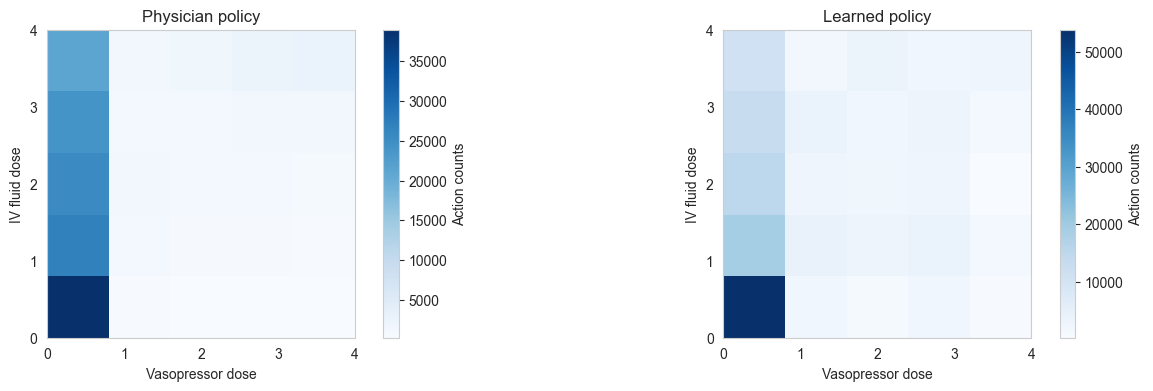

In [7]:
do_action_plot(train_df, DiscreteActionSpace, behavior_policy)

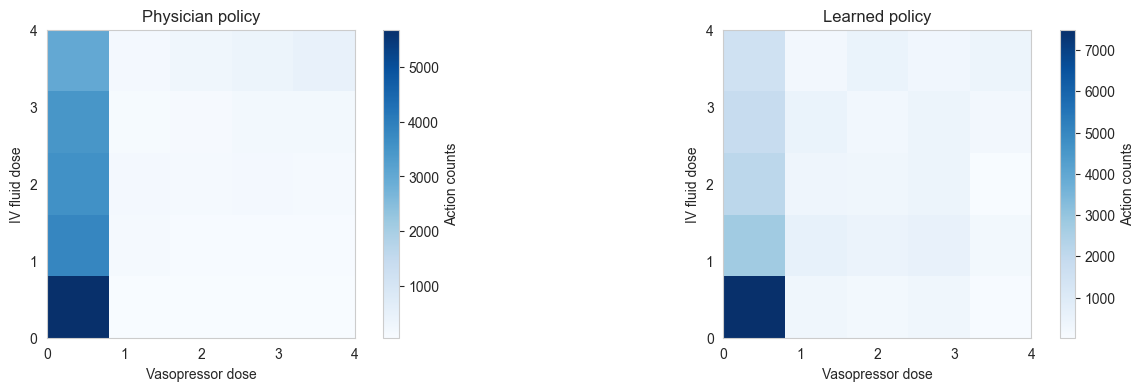

In [8]:
do_action_plot(val_df, DiscreteActionSpace, behavior_policy)

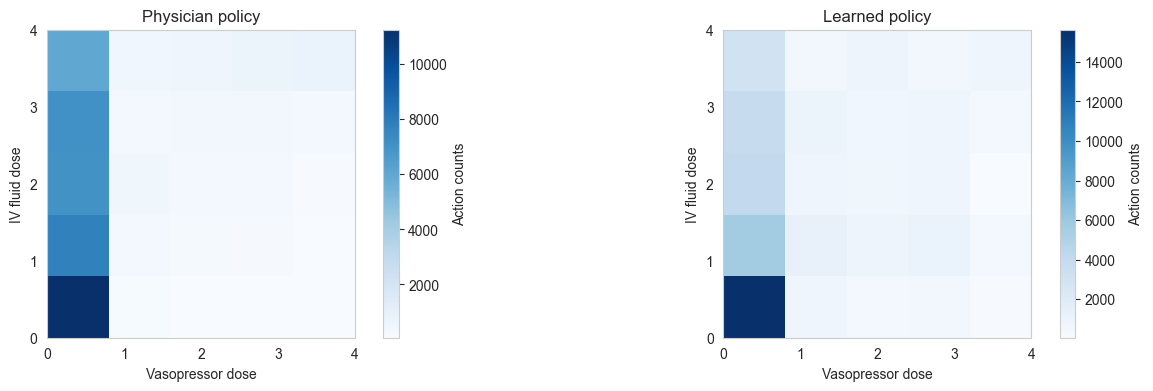

In [9]:
do_action_plot(test_df, DiscreteActionSpace, behavior_policy)

In [10]:
def compute_behavior_policy_return(traj_df: pd.DataFrame, gamma: float) -> float:
    unique_trajs = traj_df['traj'].unique()
    expected_return = 0.0
    for traj_num in unique_trajs:
        traj_view = traj_df.loc[traj_df['traj'] == traj_num].sort_values('step', ascending=True)
        rewards = traj_view['r:reward'].to_numpy()
        gammas = np.cumprod(np.full((rewards.shape[0],), gamma))
        expected_return += np.dot(rewards, gammas)
    expected_return /= unique_trajs.shape[0]
    return expected_return

def compute_learned_behavior_policy_return(traj_df: pd.DataFrame, behavior_policy_: KMeansSarsa) -> float:
    unique_trajs = traj_df['traj'].unique()
    expected_return = 0.0
    for traj_num in unique_trajs:
        traj_view = traj_df.loc[(traj_df['traj'] == traj_num) & (traj_df['step'] == 0)]
        states = traj_view['discrete_state'].to_numpy()
        actions = traj_view['a:action'].to_numpy()
        q_val = behavior_policy_._Q[states, actions]
        expected_return += q_val.item()
    expected_return /= unique_trajs.shape[0]
    return expected_return

In [11]:
compute_behavior_policy_return(test_df, 0.99)

8.188016856036338

In [12]:
compute_learned_behavior_policy_return(test_df, behavior_policy)

8.799909761258771

In [13]:
from typing import Tuple

def bin_expected_returns(df_: pd.DataFrame, behavior_policy_: KMeansSarsa) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df_['expected_return'] = behavior_policy_.get_q_values(df_['discrete_state'].to_numpy(), df_['a:action'].to_numpy())
    df_['return_bin'] = -1
    min_q_val_bin = int(np.floor(df_['expected_return'].min()))
    max_q_val_bin = int(np.ceil(df_['expected_return'].max()))
    q_val_bins = np.arange(min_q_val_bin, max_q_val_bin + 1, dtype=np.int32)
    mortality_pct = np.empty((q_val_bins.shape[0],), dtype=np.float32)
    mortality_std = np.empty((q_val_bins.shape[0],), dtype=np.float32)
    mortality_sem = np.empty((q_val_bins.shape[0],), dtype=np.float32)
    for bin_num in q_val_bins:
        bin_mask = (df_['expected_return'] >= bin_num - 0.5) & (df_['expected_return'] < bin_num + 0.5)
        df_.loc[bin_mask, 'return_bin'] = bin_num
        slice_mortality_count = df_.loc[bin_mask, 'mortality'].sum().item()
        num_states_in_bin = bin_mask.sum()
        mortality_pct[bin_num - min_q_val_bin] = slice_mortality_count / num_states_in_bin
        mortality_std[bin_num - min_q_val_bin] = np.std(df_.loc[bin_mask, 'mortality'].to_numpy())
        mortality_sem[bin_num - min_q_val_bin] = np.std(df_.loc[bin_mask, 'mortality'].to_numpy()) / np.sqrt(num_states_in_bin)
    return q_val_bins, mortality_pct, mortality_std, mortality_sem

def do_mortality_vs_expected_return_plot(df_: pd.DataFrame, behavior_policy_: KMeansSarsa):
    q_val_bins, mortality_pct, mortality_std, mortality_sem = bin_expected_returns(df_, behavior_policy_)
    f, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,4))
    sns.lineplot(df_, x='return_bin', y='mortality', ax=ax0)
    ax0.set_xlabel('Expected return')
    ax0.set_ylabel('Mortality')
    ax0.set_title('Mortality vs Expected Return')
    sns.lineplot(x=q_val_bins, y=mortality_pct, ax=ax1)
    ax1.fill_between(q_val_bins, mortality_pct - mortality_std, mortality_pct + mortality_std, alpha=0.2)
    ax1.set_xlabel('Expected return')
    ax1.set_ylabel('Mortality')
    ax1.set_title('Mortality vs Expected Return')
    df_.drop(columns=['expected_return', 'return_bin'], inplace=True)
    plt.show()

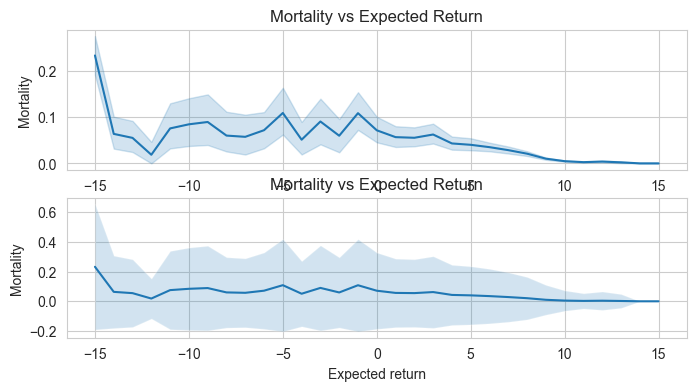

In [14]:
do_mortality_vs_expected_return_plot(test_df, behavior_policy)

In [15]:
train_df['a:action'].max()

24